# Environment Setup

In [2]:
# General
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# PyTorch
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchinfo import summary
from torchmetrics import Accuracy, JaccardIndex

# CubiCasa
from floortrans.loaders import FloorplanSVG
from floortrans.loaders.augmentations import (RandomCropToSizeTorch,
                                              ResizePaddedTorch,
                                              Compose,
                                              DictToTensor,
                                              ColorJitterTorch,
                                              RandomRotations)

# Own modules
from models.deeplabv3plus import DeepLabV3Plus
from evaluation_metrics import Metrics, timer

# Release GPU memory
torch.cuda.empty_cache()
print("GPU memory has been released.")

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using device: CPU")


print("Setup complete.")

GPU memory has been released.
Using device: NVIDIA GeForce RTX 3060 Laptop GPU
Setup complete.


# Data Preprocessing and Augmentations

In [3]:
IMAGE_SIZE = (256, 256)

aug = Compose([
    # transforms.RandomChoice([
    #     RandomCropToSizeTorch(data_format='dict', size=IMAGE_SIZE),
    #     ResizePaddedTorch((0, 0), data_format='dict', size=IMAGE_SIZE)
    # ]),
    ResizePaddedTorch((0, 0), data_format='dict', size=IMAGE_SIZE),
    RandomRotations(format='cubi'),
    DictToTensor(),
    # ColorJitterTorch()
])

# Dataset

In [4]:
DATA_PATH = 'data/cubicasa5k/'
TRAIN_PATH = 'train.txt'
VAL_PATH = 'val.txt'
FORMAT = 'lmdb'

train_set = FloorplanSVG(
    DATA_PATH, 
    TRAIN_PATH, 
    format=FORMAT, 
    augmentations=aug
)

# Use this in the meantime to prevent kernel dying
# train_set = Subset(full_train_set, list(range(1000)))

val_set = FloorplanSVG(
    DATA_PATH, 
    VAL_PATH, 
    format=FORMAT, 
    augmentations=DictToTensor()
)

print('Train set size:', len(train_set))
print('Validation set size:', len(val_set))

Train set size: 4200
Validation set size: 400


In [5]:
sample = train_set[10]

# Print the image shape
print('Image shape:', sample['image'].shape)

# Print the overall label shape
print('Label shape (overall):', sample['label'].shape)

# Print the shape for room and icon segmentation maps
print('\nLabel shape (rooms): ', sample['label'][21].shape)
print('Label shape (icons):', sample['label'][22].shape)
print()

# Print the shape for the 21 heatmap channels
for i in range(21):
    print(f'Label shape (heatmap {i+1}):', sample['label'][i].shape)


Image shape: torch.Size([3, 256, 256])
Label shape (overall): torch.Size([23, 256, 256])

Label shape (rooms):  torch.Size([256, 256])
Label shape (icons): torch.Size([256, 256])

Label shape (heatmap 1): torch.Size([256, 256])
Label shape (heatmap 2): torch.Size([256, 256])
Label shape (heatmap 3): torch.Size([256, 256])
Label shape (heatmap 4): torch.Size([256, 256])
Label shape (heatmap 5): torch.Size([256, 256])
Label shape (heatmap 6): torch.Size([256, 256])
Label shape (heatmap 7): torch.Size([256, 256])
Label shape (heatmap 8): torch.Size([256, 256])
Label shape (heatmap 9): torch.Size([256, 256])
Label shape (heatmap 10): torch.Size([256, 256])
Label shape (heatmap 11): torch.Size([256, 256])
Label shape (heatmap 12): torch.Size([256, 256])
Label shape (heatmap 13): torch.Size([256, 256])
Label shape (heatmap 14): torch.Size([256, 256])
Label shape (heatmap 15): torch.Size([256, 256])
Label shape (heatmap 16): torch.Size([256, 256])
Label shape (heatmap 17): torch.Size([256, 25

In [5]:
print('Image: ', sample['image'])

Image:  tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])


In [6]:
print('Label: ', sample['label'])

Label:  tensor([[[-9.5865e-18, -8.6483e-18, -9.3129e-18,  ..., -5.0288e-18,
          -5.4577e-18, -5.1156e-18],
         [-3.6145e-18, -2.1257e-18, -2.1030e-18,  ..., -1.6470e-17,
          -1.7657e-17, -1.8607e-17],
         [ 1.8247e-17,  1.8930e-17,  1.9285e-17,  ..., -3.9281e-18,
          -2.3863e-18, -1.2612e-18],
         ...,
         [-3.0045e-17, -3.0373e-17, -3.0368e-17,  ..., -4.5861e-18,
          -3.5487e-18, -4.2846e-18],
         [-8.6625e-19,  1.6024e-18,  2.9399e-18,  ...,  8.2687e-18,
           7.2684e-18,  5.4104e-18],
         [ 3.4539e-17,  3.6435e-17,  3.7736e-17,  ..., -8.2955e-18,
          -6.1048e-18, -5.1632e-18]],

        [[ 8.4695e-18,  9.3581e-18,  9.5146e-18,  ...,  3.7879e-17,
           3.6521e-17,  3.5989e-17],
         [ 9.8525e-18,  1.0122e-17,  1.0499e-17,  ..., -2.1441e-17,
          -2.0457e-17, -1.9671e-17],
         [-1.7523e-17, -1.6295e-17, -1.4439e-17,  ...,  9.9474e-18,
           8.4150e-18,  8.5792e-18],
         ...,
         [ 1.3791

# Save label to numpy/tensor

In [7]:
label_tensor = sample['label']
label_np = label_tensor.numpy()

# Save the label as a numpy array
np.save('model_outputs/floorplan_pred.npy', label_np)

# Save as tensor
torch.save(label_tensor, 'model_outputs/floorplan_pred.pt')


# Visualize Images and Labels

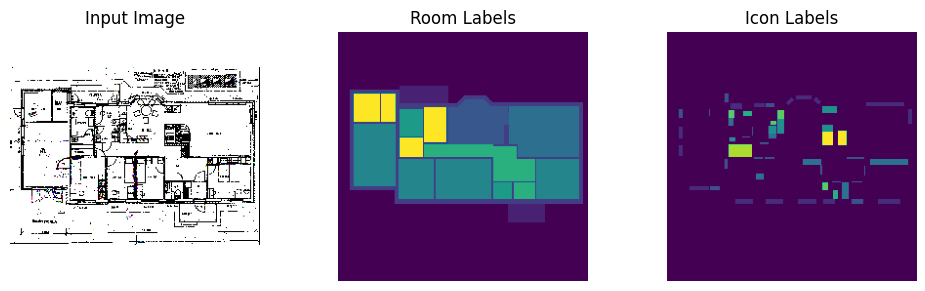

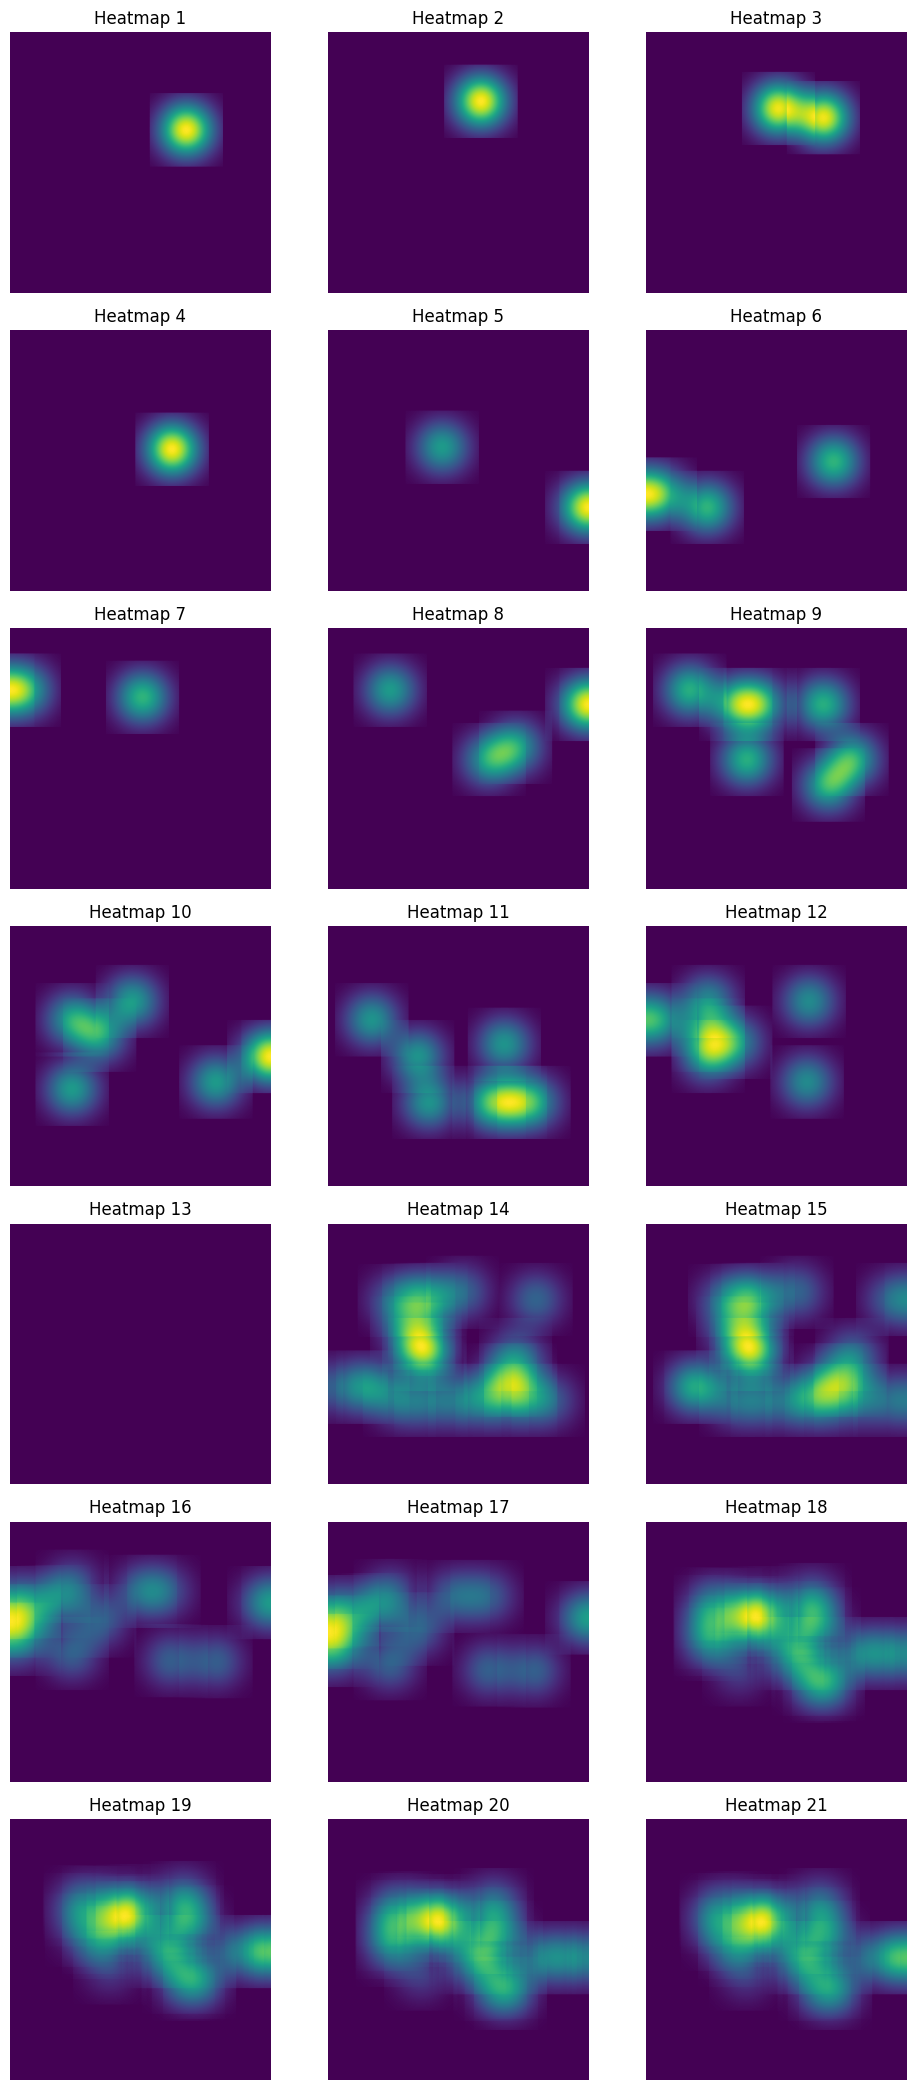

In [11]:
# Convert back to [0, 255] range
tensor_image = sample['image'] * 255.0

np_image = tensor_image.numpy().astype(np.uint8)  # Convert to unsigned 8-bit integer

# Transpose to [H, W, 3] from [3, H, W]
np_image = np.transpose(np_image, (1, 2, 0))

# Create figure with 1 row and 3 columns for the first set of visualizations
fig, axes = plt.subplots(1, 3, figsize=(10, 3))  # 1 row, 3 columns

# Input image
axes[0].imshow(np_image)
axes[0].axis('off')  # Remove the axes
axes[0].set_title('Input Image')

# Room segmentation map
axes[1].imshow(sample['label'][21])
axes[1].axis('off')  # Remove the axes
axes[1].set_title('Room Labels')

# Icon segmentation map
axes[2].imshow(sample['label'][22])
axes[2].axis('off')
axes[2].set_title('Icon Labels')

plt.tight_layout()
plt.show()

# Now display the heatmaps, 3 heatmaps per row
num_heatmaps = 21
cols = 3
rows = (num_heatmaps + cols - 1) // cols  # Calculate number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(10, 3 * rows))

for i in range(num_heatmaps):
    row = i // cols
    col = i % cols
    axes[row, col].imshow(sample['label'][i])
    axes[row, col].axis('off')
    axes[row, col].set_title(f'Heatmap {i+1}')

# If there are empty spaces in the last row (if heatmaps < total subplots), hide them
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])  # Remove unused subplots

plt.tight_layout()
plt.show()


# DataLoader

In [9]:
NUM_WORKERS = 0
BATCH_SIZE = 16

train_loader = DataLoader(
    train_set, 
    batch_size=BATCH_SIZE, 
    num_workers=NUM_WORKERS, 
    shuffle=True, 
    pin_memory=True
)

val_loader = DataLoader(
    val_set, 
    batch_size=1, 
    num_workers=NUM_WORKERS, 
    pin_memory=True
)

print(f'Length of train dataloader: {len(train_loader)} batches of size {BATCH_SIZE}')
print(f'Length of val dataloader: {len(val_loader)} batches of size {BATCH_SIZE}')

batch_sample = next(iter(train_loader))
print('\nBatch image shape: ', batch_sample['image'].shape)
print('Batch label shape: ', batch_sample['label'].shape)

Length of train dataloader: 263 batches of size 16
Length of val dataloader: 400 batches of size 16

Batch image shape:  torch.Size([16, 3, 256, 256])
Batch label shape:  torch.Size([16, 23, 256, 256])


# Model Setup

For reference, here are the 23 classes:  

- **Rooms (12):** "Background", "Outdoor", "Wall", "Kitchen", "Living Room" ,"Bed Room", "Bath", "Entry", "Railing", "Storage", "Garage", "Undefined"  

- **Icons (11):** "No Icon", "Window", "Door", "Closet", "Electrical Applience" ,"Toilet", "Sink", "Sauna Bench", "Fire Place", "Bathtub", "Chimney"

In [10]:
model = DeepLabV3Plus(backbone='resnet50', attention=False)
model.to(device)

summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]))

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3Plus                                      [16, 12, 256, 256]        --
├─Backbone: 1-1                                    [16, 256, 64, 64]         --
│    └─ResNet: 2-1                                 --                        2,049,000
│    │    └─Conv2d: 3-1                            [16, 64, 128, 128]        9,408
│    │    └─BatchNorm2d: 3-2                       [16, 64, 128, 128]        128
│    │    └─ReLU: 3-3                              [16, 64, 128, 128]        --
│    │    └─MaxPool2d: 3-4                         [16, 64, 64, 64]          --
│    │    └─Sequential: 3-5                        [16, 256, 64, 64]         215,808
│    │    └─Sequential: 3-6                        [16, 512, 32, 32]         1,219,584
│    │    └─Sequential: 3-7                        [16, 1024, 16, 16]        7,098,368
│    │    └─Sequential: 3-8                        [16, 2048, 8, 8]          14,964,7

In [11]:
# Verifying output shapes
sample_input = torch.randn(BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)

room_output, icon_output, heatmap_output = model(sample_input)

print("Room Output Shape:", room_output.shape)  # Expected: [16, 12, 256, 256]
print("Icon Output Shape:", icon_output.shape)  # Expected: [16, 11, 256, 256]
print("Heatmap Output Shape:", heatmap_output.shape)  # Expected: [16, 21, 256, 256]

Room Output Shape: torch.Size([16, 12, 256, 256])
Icon Output Shape: torch.Size([16, 11, 256, 256])
Heatmap Output Shape: torch.Size([16, 21, 256, 256])


: 

# Simplified Training and Validation Loop

In [2]:
import torch.nn as nn

# Loss functions
room_loss_fn = nn.CrossEntropyLoss()
icon_loss_fn = nn.CrossEntropyLoss()
heatmap_loss_fn = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Training loop
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0  # Initialize as a scalar

    # Wrap dataloader with tqdm to show progress bar
    for batch in tqdm(dataloader, desc="Training", leave=False):
        images = batch['image'].float().to(device)

        room_labels = batch['label'][:, 21].long().to(device)
        icon_labels = batch['label'][:, 22].long().to(device)
        heatmap_labels = batch['label'][:, 0:21].to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass
        room_output, icon_output, heatmap_output = model(images)

        # Compute losses
        room_loss = room_loss_fn(room_output, room_labels)
        icon_loss = icon_loss_fn(icon_output, icon_labels)
        heatmap_loss = heatmap_loss_fn(heatmap_output, heatmap_labels)

        # Combine losses
        loss = room_loss + icon_loss + heatmap_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()  # Accumulate the scalar value of the loss

    return total_loss / len(dataloader)

# Validation loop
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0.0  # Initialize as a scalar

    # Wrap dataloader with tqdm to show progress bar
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating", leave=False):
            images = batch['image'].float().to(device)

            room_labels = batch['label'][:, 21].long().to(device)
            icon_labels = batch['label'][:, 22].long().to(device)
            heatmap_labels = batch['label'][:, 0:21].to(device)

            # Forward pass
            room_output, icon_output, heatmap_output = model(images)

            # Compute losses
            room_loss = room_loss_fn(room_output, room_labels)
            icon_loss = icon_loss_fn(icon_output, icon_labels)
            heatmap_loss = heatmap_loss_fn(heatmap_output, heatmap_labels)

            loss = room_loss + icon_loss + heatmap_loss

            total_loss += loss.item()  # Accumulate the scalar value
    
    return total_loss / len(dataloader)

# Train and validate model
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)

    print(f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")


Epoch 1/100


Train Loss: 1.2830 - Val Loss: 2.4817
Epoch 2/100


Train Loss: 1.0190 - Val Loss: 2.2166
Epoch 3/100


Train Loss: 0.9721 - Val Loss: 2.5432
Epoch 4/100


Train Loss: 0.9475 - Val Loss: 2.3250
Epoch 5/100


Train Loss: 0.9264 - Val Loss: 2.2079
Epoch 6/100


Train Loss: 0.9130 - Val Loss: 2.4793
Epoch 7/100


Train Loss: 0.9012 - Val Loss: 2.3790
Epoch 8/100


Training:   4%|▍         | 10/263 [00:28<11:26,  2.71s/it]

# Loss Function

# Training Hyperparameters

In [12]:
# EPOCHS = 100

# CRITERION = torch.nn.CrossEntropyLoss()

# initial_lr = 0.001
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr=initial_lr, momentum=0.95, weight_decay=1e-4, nesterov=True)

# # Poly learning rate policy (used in DeepLabV3+ paper)
# class PolyLR(torch.optim.lr_scheduler._LRScheduler):
#     def __init__(self, optimizer, max_iters, power=0.9, last_epoch=-1):
#         self.max_iters = max_iters
#         self.power = power
#         super(PolyLR, self).__init__(optimizer, last_epoch)

#     def get_lr(self):
#         return [base_lr * (1 - self.last_epoch / self.max_iters) ** self.power for base_lr in self.base_lrs]

# max_iters = EPOCHS * len(train_loader)
# SCHEDULER = PolyLR(OPTIMIZER, max_iters)

# Training and Validation Loop

In [ ]:
# EPOCHS = 400
# OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001)
# CRITERION = MultiTaskLossWrapper(task_num=2)

# def timer(start_time = None): 
#     return time.time() if start_time == None else time.time() - start_time


# def train_evaluate(model, 
#                    train_loader, 
#                    val_loader, 
#                    device,
#                    loss_fn,
#                    optimizer, 
#                    epochs,
#                    early_stop_threshold=15,
#                    save_prefix='deeplabv3plus',
#                    save_path='saved_models'):
    
#     # Store results, to be returned
#     train_loss_list = []
#     train_room_cpa_list = []
#     train_room_mpa_list = []
#     train_room_miou_list = []
#     train_room_fwiou_list = []
#     train_icon_cpa_list = []
#     train_icon_mpa_list = []
#     train_icon_miou_list = []
#     train_icon_fwiou_list = []

#     val_loss_list = []
#     val_room_cpa_list = []
#     val_room_mpa_list = []
#     val_room_miou_list = []
#     val_room_fwiou_list = []
#     val_icon_cpa_list = []
#     val_icon_mpa_list = []
#     val_icon_miou_list = []
#     val_icon_fwiou_list = []

#     # Training metrics
#     train_room_cpa = Accuracy(task='multiclass', num_classes=12, average=None).to(device)
#     train_room_mpa = Accuracy(task='multiclass', num_classes=12, average='macro').to(device)
#     train_room_miou = JaccardIndex(task='multiclass', num_classes=12, average='macro').to(device)
#     train_room_fwiou = JaccardIndex(task='multiclass', num_classes=12, average='weighted').to(device)

#     train_icon_cpa = Accuracy(task='multiclass', num_classes=11, average=None).to(device)
#     train_icon_mpa = Accuracy(task='multiclass', num_classes=11, average='macro').to(device)
#     train_icon_miou = JaccardIndex(task='multiclass', num_classes=11, average='macro').to(device)
#     train_icon_fwiou = JaccardIndex(task='multiclass', num_classes=11, average='weighted').to(device)

#     # Validation metrics
#     val_room_cpa = Accuracy(task='multiclass', num_classes=12, average=None).to(device)
#     val_room_mpa = Accuracy(task='multiclass', num_classes=12, average='macro').to(device)
#     val_room_miou = JaccardIndex(task='multiclass', num_classes=12, average='macro').to(device)
#     val_room_fwiou = JaccardIndex(task='multiclass', num_classes=12, average='weighted').to(device)

#     val_icon_cpa = Accuracy(task='multiclass', num_classes=11, average=None).to(device)
#     val_icon_mpa = Accuracy(task='multiclass', num_classes=11, average='macro').to(device)
#     val_icon_miou = JaccardIndex(task='multiclass', num_classes=11, average='macro').to(device)
#     val_icon_fwiou = JaccardIndex(task='multiclass', num_classes=11, average='weighted').to(device)
    
#     best_loss = np.inf
#     not_improving = 0
    
#     # Save models in this directory
#     os.makedirs(save_path, exist_ok=True)

#     # Start timer
#     train_start = timer()
#     print('Start training process...')

#     for epoch in range(1, epochs + 1):
#         epoch_start = timer()
        
#         # Training loop
#         print(f'Epoch {epoch} train process started...')
#         model.train()

#         epoch_train_loss = 0.0

#         for batch in tqdm(train_loader):
#             images = batch['image'].to(device)
#             room_labels = batch['label'][:, 0].to(device)
#             icon_labels = batch['label'][:, 1].to(device)

#             # Reset gradients since PyTorch accumulates previous gradients
#             optimizer.zero_grad()

#             # Forward pass
#             room_output, icon_output = model(images)

#             # Calculate loss
#             loss = loss_fn(room_output, icon_output, room_labels, icon_labels)
#             epoch_train_loss += loss.item()

#             # Backward pass
#             loss.backward()

#             # Update weights
#             optimizer.step()

#             # Update metrics
#             train_room_cpa.update(room_output, room_labels)
#             train_room_mpa.update(room_output, room_labels)
#             train_room_miou.update(room_output, room_labels)
#             train_room_fwiou.update(room_output, room_labels)

#             train_icon_cpa.update(icon_output, icon_labels)
#             train_icon_mpa.update(icon_output, icon_labels)
#             train_icon_miou.update(icon_output, icon_labels)
#             train_icon_fwiou.update(icon_output, icon_labels)

#         # Calculate training metrics
#         train_room_cpa_value = train_room_cpa.compute()
#         train_room_mpa_value = train_room_mpa.compute().item()
#         train_room_miou_value = train_room_miou.compute().item()
#         train_room_fwiou_value = train_room_fwiou.compute().item()

#         train_icon_cpa_value = train_icon_cpa.compute()
#         train_icon_mpa_value = train_icon_mpa.compute().item()
#         train_icon_miou_value = train_icon_miou.compute().item()
#         train_icon_fwiou_value = train_icon_fwiou.compute().item()

#         # Reset metrics
#         train_room_cpa.reset()
#         train_room_mpa.reset()
#         train_room_miou.reset()
#         train_room_fwiou.reset()

#         train_icon_cpa.reset()
#         train_icon_mpa.reset()
#         train_icon_miou.reset()
#         train_icon_fwiou.reset()

        
#         # Validation loop
#         print(f'Epoch {epoch} validation process started...')
#         model.eval()

#         epoch_val_loss = 0.0

#         with torch.no_grad():
#             for batch in tqdm(val_loader):
#                 images = batch['image'].to(device)
#                 room_labels = batch['label'][:, 0].to(device)
#                 icon_labels = batch['label'][:, 1].to(device)

#                 # Get model predictions
#                 room_output, icon_output = model(images)

#                 # Calculate loss
#                 loss = loss_fn(room_output, icon_output, room_labels, icon_labels)
#                 epoch_val_loss += loss.item()

#                 # Update metrics
#                 val_room_cpa.update(room_output, room_labels)
#                 val_room_mpa.update(room_output, room_labels)
#                 val_room_miou.update(room_output, room_labels)
#                 val_room_fwiou.update(room_output, room_labels)

#                 val_icon_cpa.update(icon_output, icon_labels)
#                 val_icon_mpa.update(icon_output, icon_labels)
#                 val_icon_miou.update(icon_output, icon_labels)
#                 val_icon_fwiou.update(icon_output, icon_labels)

#         # Calculate validation metrics
#         val_room_cpa_value = val_room_cpa.compute()
#         val_room_mpa_value = val_room_mpa.compute().item()
#         val_room_miou_value = val_room_miou.compute().item()
#         val_room_fwiou_value = val_room_fwiou.compute().item()

#         val_icon_cpa_value = val_icon_cpa.compute()
#         val_icon_mpa_value = val_icon_mpa.compute().item()
#         val_icon_miou_value = val_icon_miou.compute().item()
#         val_icon_fwiou_value = val_icon_fwiou.compute().item()

#         # Reset metrics
#         val_room_cpa.reset()
#         val_room_mpa.reset()
#         val_room_miou.reset()
#         val_room_fwiou.reset()

#         val_icon_cpa.reset()
#         val_icon_mpa.reset()
#         val_icon_miou.reset()
#         val_icon_fwiou.reset()


#         # Print epoch results
#         print(f'Epoch {epoch} train process is completed.')
#         print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#         print(f'\nEpoch {epoch} train process results:\n')

#         print(f'Train Time: {timer(epoch_start):.3f} secs')

#         # Combine room and icon metrics for training, including loss
#         print(f'Train Room - Loss: {epoch_train_loss / len(train_loader):.3f}, MPA: {train_room_mpa_value:.3f}, mIOU: {train_room_miou_value:.3f}, fwIOU: {train_room_fwiou_value:.3f}')
#         print(f'Train Icon - Loss: {epoch_train_loss / len(train_loader):.3f}, MPA: {train_icon_mpa_value:.3f}, mIOU: {train_icon_miou_value:.3f}, fwIOU: {train_icon_fwiou_value:.3f}')

#         print(f'\nVal process results:')

#         # Combine room and icon metrics for validation, including loss
#         print(f'Val Room - Loss: {epoch_val_loss / len(val_loader):.3f}, MPA: {val_room_mpa_value:.3f}, mIOU: {val_room_miou_value:.3f}, fwIOU: {val_room_fwiou_value:.3f}')
#         print(f'Val Icon - Loss: {epoch_val_loss / len(val_loader):.3f}, MPA: {val_icon_mpa_value:.3f}, mIOU: {val_icon_miou_value:.3f}, fwIOU: {val_icon_fwiou_value:.3f}')


#         # Append results
#         train_loss_list.append(epoch_train_loss / len(train_loader))
#         train_room_cpa_list.append(train_room_cpa_value)
#         train_room_mpa_list.append(train_room_mpa_value)
#         train_room_miou_list.append(train_room_miou_value)
#         train_room_fwiou_list.append(train_room_fwiou_value)
#         train_icon_cpa_list.append(train_icon_cpa_value)
#         train_icon_mpa_list.append(train_icon_mpa_value)
#         train_icon_miou_list.append(train_icon_miou_value)
#         train_icon_fwiou_list.append(train_icon_fwiou_value)

#         val_loss_list.append(epoch_val_loss / len(val_loader))
#         val_room_cpa_list.append(val_room_cpa_value)
#         val_room_mpa_list.append(val_room_mpa_value)
#         val_room_miou_list.append(val_room_miou_value)
#         val_room_fwiou_list.append(val_room_fwiou_value)
#         val_icon_cpa_list.append(val_icon_cpa_value)
#         val_icon_mpa_list.append(val_icon_mpa_value)
#         val_icon_miou_list.append(val_icon_miou_value)
#         val_icon_fwiou_list.append(val_icon_fwiou_value)

#         # Save model if validation loss is improved
#         if (epoch_val_loss / len(val_loader)) < best_loss:
#             print(f'\nLoss decreased from {best_loss:.3f} to {(epoch_val_loss / len(val_loader)):.3f}!')
#             best_loss = (epoch_val_loss / len(val_loader))

#             not_improving = 0 # Reset counter

#             print('Saving the model with the best loss value...')
#             torch.save(model.state_dict(), f'{save_path}/{save_prefix}.pt')
        
#         else:
#             not_improving += 1
#             print(f'\nLoss did not decrease for {not_improving} epoch(s)!')

#             if not_improving == early_stop_threshold:
#                 print(f'Stopping training process because loss did not decrease for {early_stop_threshold} epochs!')
#                 break
        
#         print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

#     print(f'Train process is completed in {(timer(train_start)) / 60:.3f} minutes.')


#     return {
#         'train_loss': train_loss_list,
#         'train_room_cpa': train_room_cpa_list,
#         'train_room_mpa': train_room_mpa_list,
#         'train_room_miou': train_room_miou_list,
#         'train_room_fwiou': train_room_fwiou_list,
#         'train_icon_cpa': train_icon_cpa_list,
#         'train_icon_mpa': train_icon_mpa_list,
#         'train_icon_miou': train_icon_miou_list,
#         'train_icon_fwiou': train_icon_fwiou_list,
#         'val_loss': val_loss_list,
#         'val_room_cpa': val_room_cpa_list,
#         'val_room_mpa': val_room_mpa_list,
#         'val_room_miou': val_room_miou_list,
#         'val_room_fwiou': val_room_fwiou_list,
#         'val_icon_cpa': val_icon_cpa_list,
#         'val_icon_mpa': val_icon_mpa_list,
#         'val_icon_miou': val_icon_miou_list,
#         'val_icon_fwiou': val_icon_fwiou_list
#     }


# # Run training and validation process
# history = train_evaluate(model,
#                          train_loader,
#                          val_loader,
#                          device,
#                          CRITERION,
#                          OPTIMIZER,
#                          EPOCHS,
#                          save_prefix=f'deeplabv3plus_{model.backbone_name}')

# Visualizing Performance

In [16]:
# class Plot():
#     def __init__(self, results):
#         self.results = results

#         self.visualize(metric1="tr_iou", 
#                        metric2="val_iou", 
#                        label1="Train IoU",
#                        label2 ="Validation IoU", 
#                        title="Mean Intersection Over Union Learning Curve", 
#                        ylabel="mIoU Score")

#         self.visualize(metric1="tr_pa", 
#                        metric2="val_pa", 
#                        label1="Train PA",
#                        label2="Validation PA", 
#                        title="Pixel Accuracy Learning Curve", 
#                        ylabel="PA Score")

#         self.visualize(metric1="tr_loss", 
#                        metric2="val_loss", 
#                        label1="Train Loss",
#                        label2="Validation Loss", 
#                        title="Loss Learning Curve", 
#                        ylabel="Loss Value")

#     def plot(self, metric, label): 
#         plt.plot(self.results[metric], label=label)

#     def decorate(self, ylabel, title): 
#         plt.title(title)
#         plt.xlabel("Epochs")
#         plt.ylabel(ylabel)
#         plt.legend()
#         plt.show()

#     def visualize(self, metric1, metric2, label1, label2, title, ylabel):
#         plt.figure(figsize=(10, 5))
#         self.plot(metric1, label1)
#         self.plot(metric2, label2)
#         self.decorate(ylabel, title)


# Plot(history)

# Testing 

In [17]:
# class Test():
#     def __init__(self, model, test_loader, loss_fn, device):
#         self.model = model
#         self.test_loader = test_loader
#         self.loss_fn = loss_fn
#         self.device = device
    
#     def run(self):
#         self.model.eval()
#         test_loss = 0
#         test_iou = 0
#         test_pixel_acc = 0
#         test_len = len(self.test_loader)

#         imgs = []
#         gts = []
#         preds = []

#         with torch.no_grad():
#             for batch in tqdm(self.test_loader):
#                 imgs_batch = batch['image']
#                 gts_batch = batch['label']
#                 imgs_batch, gts_batch = imgs_batch.to(self.device), gts_batch.to(self.device)

#                 # Forward pass
#                 preds_batch = self.model(imgs_batch)
                
#                 # Calculate metrics
#                 metrics = Metrics(preds_batch, gts_batch, self.loss_fn)
#                 test_loss += metrics.loss().item()
#                 test_iou += metrics.mIOU()
#                 test_pixel_acc += metrics.PixelAcc()

#                 # Collect data for visualization
#                 preds_batch = torch.argmax(preds_batch, dim=1)
#                 imgs.extend(imgs_batch.cpu())
#                 gts.extend(gts_batch.cpu())
#                 preds.extend(preds_batch.cpu())

#         # Calculate average metrics
#         test_loss /= test_len
#         test_iou /= test_len
#         test_pixel_acc /= test_len

#         return imgs, gts, preds, test_loss, test_iou, test_pixel_acc


# test = Test(model, test_loader, CRITERION, device)
# imgs, gts, preds, test_loss, test_iou, test_pixel_acc = test.run()

# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test mIoU: {test_iou:.4f}")
# print(f"Test PA: {test_pixel_acc:.4f}")